# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:


# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
!pip install matplotlib==2.2.0
!pip install tensorflow==1.4.0
!pip install tensorflow-gpu==1.4.0

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 12.5MB 55kB/s  eta 0:00:01
    100% |████████████████████████████████| 952kB 727kB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 41.2MB 16kB/s  eta 0:00:01
    100% |████████████████████████████████| 1.7MB 417kB/s eta 0:00:01
  Found existing installation: tensorflow-tensorboard 0.1.5
    Uninstalling tensorflow-tensorboard-0.1.5:
      Successfully uninstalled tensorflow-tensorboard-0.1.5
  Found existing installation: tensorflow 1.3.0
    Uninstalling tensorflow-1.3.0:
      Successfully uninstalled tensorflow-1.3.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

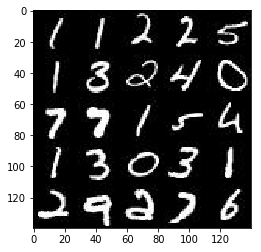

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

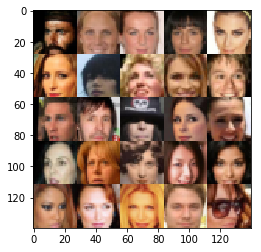

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse = reuse):
        # Conv Layer - 28 x 28 x depth -> 28 x 28 x 64
        conv_1 = tf.layers.conv2d(images, 64, 3, strides = 1, padding = 'same')
        conv_1 = tf.maximum(conv_1, conv_1 * alpha)
        # Conv Layer - 28 x 28 x 64 -> 14 x 14 x 64
        conv_2 = tf.layers.conv2d(conv_1, 64, 3, strides = 2, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_2 = tf.layers.batch_normalization(conv_2, training = True)
        conv_2 = tf.maximum(conv_2, conv_2 * alpha)
        # Conv Layer - 14 x 14 x 64 -> 14 x 14 x 128
        conv_3 = tf.layers.conv2d(conv_2, 128, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_3 = tf.layers.batch_normalization(conv_3, training = True)
        conv_3 = tf.maximum(conv_3, conv_3 * alpha)
        # Conv Layer - 14 x 14 x 128 -> 7 x 7 x 128
        conv_4 = tf.layers.conv2d(conv_3, 128, 3, strides = 2, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_4 = tf.layers.batch_normalization(conv_4, training = True)
        conv_4 = tf.maximum(conv_4, conv_4 * alpha)
        # Conv Layer - 7 x 7 x 128 -> 7 x 7 x 256
        conv_5 = tf.layers.conv2d(conv_4, 256, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_5 = tf.layers.batch_normalization(conv_5, training = True)
        conv_5 = tf.maximum(conv_5, conv_5 * alpha)
        # Conv Layer - 7 X 7 X 256 -> 4 x 4 x 512
        conv_6 = tf.layers.conv2d(conv_5, 512, 3, strides = 2, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_6 = tf.layers.batch_normalization(conv_6, training = True)
        conv_6 = tf.maximum(conv_6, conv_6 * alpha)
        # Flatten Layer - 4 x 4 x 512 -> 1 x 4 * 4 * 512
        flat = tf.reshape(conv_6, (-1, 4 * 4 * 512))
        # Fully Connected Layer - 1 x 4 * 4 * 512 -> 1
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse = not is_train):
        # Dense Layer - size(z) ->  7 x 7 x 1024
        dense = tf.layers.dense(z, 7 * 7 * 1024)
        input_to_conv = tf.reshape(dense, (-1, 7, 7, 1024))
        input_to_conv = tf.layers.batch_normalization(input_to_conv, training = is_train)
        input_to_conv = tf.nn.relu(input_to_conv)
        # Conv Layer - 7 x 7 x 1024 -> 7 x 7 x 512
        conv_1 = tf.layers.conv2d(input_to_conv, 512, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_1 = tf.layers.batch_normalization(conv_1, training = is_train)
        conv_1 = tf.nn.relu(conv_1)
        # Deconv Layer - 7 x 7 x 512 -> 14 x 14 x 512
        conv_2 = tf.layers.conv2d_transpose(conv_1, 512, 3, strides = 2, padding = 'same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_2 = tf.layers.batch_normalization(conv_2, training = is_train)
        conv_2 = tf.nn.relu(conv_2)
        # Conv Layer - 14 x 14 x 512 -> 14 x 14 x 256
        conv_3 = tf.layers.conv2d(conv_2, 256, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_3 = tf.layers.batch_normalization(conv_3, training = is_train)
        conv_3 = tf.nn.relu(conv_3)
        # Deconv Layer - 14 x 14 x 256 -> 28 x 28 x 256
        conv_4 = tf.layers.conv2d_transpose(conv_3, 256, 3, strides = 2, padding = 'same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_4 = tf.layers.batch_normalization(conv_4, training = is_train)
        conv_4 = tf.nn.relu(conv_4)
        # Conv Layer - 28 x 28 x 256 -> 28 x 28 x 128
        conv_5 = tf.layers.conv2d(conv_4, 128, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_5 = tf.layers.batch_normalization(conv_5, training = is_train)
        conv_5 = tf.nn.relu(conv_5)
        # Conv Layer - 28 x 28 x 128 -> 28 x 28 x 64
        conv_6 = tf.layers.conv2d(conv_5, 64, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_6 = tf.layers.batch_normalization(conv_6, training = is_train)
        conv_6 = tf.nn.relu(conv_6)
        # Conv Layer - 28 x 28 x 128 -> 28 x 28 x 32
        conv_7 = tf.layers.conv2d(conv_6, 32, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_7 = tf.layers.batch_normalization(conv_7, training = is_train)
        conv_7 = tf.nn.relu(conv_7)
        # Conv Layer - 28 x 28 x 32 -> 28 x 28 x 16
        conv_8 = tf.layers.conv2d(conv_7, 16, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv_8 = tf.layers.batch_normalization(conv_8, training = is_train)
        conv_8 = tf.nn.relu(conv_8)
        # Conv Layer - 28 x 28 x 16 -> 28 x 28 x out_channel_dim
        conv_9 = tf.layers.conv2d(conv_8, out_channel_dim, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(conv_9)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                         labels = tf.ones_like(d_model_real)* 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                         labels = tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                    labels = tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Create random noise for the generator's input
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {inputs_real: batch_images, 
                                                            inputs_z: batch_z, 
                                                            lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {inputs_z: batch_z, 
                                                           inputs_real: batch_images, 
                                                           lr: learning_rate})
                
                # Print losses
                if steps % 10 == 0:
                    # Evaluate losses and print them
                    train_loss_d = d_loss.eval({inputs_z: batch_z, 
                                                    inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d), 
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Display generated images
                    if steps % 100 == 0:
                        show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
        print('Training Finished!')
                    
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 0.8530... Generator Loss: 1.1425
Epoch 1/3... Discriminator Loss: 0.4513... Generator Loss: 4.2902
Epoch 1/3... Discriminator Loss: 3.2289... Generator Loss: 0.0811
Epoch 1/3... Discriminator Loss: 0.7240... Generator Loss: 2.7687
Epoch 1/3... Discriminator Loss: 0.8801... Generator Loss: 1.3894
Epoch 1/3... Discriminator Loss: 1.3440... Generator Loss: 1.0681
Epoch 1/3... Discriminator Loss: 0.8867... Generator Loss: 1.0781
Epoch 1/3... Discriminator Loss: 1.1055... Generator Loss: 1.0258
Epoch 1/3... Discriminator Loss: 2.4798... Generator Loss: 4.0430
Epoch 1/3... Discriminator Loss: 0.7413... Generator Loss: 1.6733


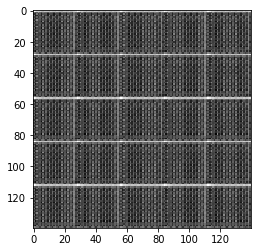

Epoch 1/3... Discriminator Loss: 0.8576... Generator Loss: 2.3394
Epoch 1/3... Discriminator Loss: 1.5900... Generator Loss: 0.4169
Epoch 1/3... Discriminator Loss: 1.3161... Generator Loss: 0.6382
Epoch 1/3... Discriminator Loss: 0.9974... Generator Loss: 1.9858
Epoch 1/3... Discriminator Loss: 1.0375... Generator Loss: 0.9883
Epoch 1/3... Discriminator Loss: 0.8944... Generator Loss: 1.3033
Epoch 1/3... Discriminator Loss: 2.1425... Generator Loss: 1.8831
Epoch 1/3... Discriminator Loss: 1.2414... Generator Loss: 0.7795
Epoch 1/3... Discriminator Loss: 1.0346... Generator Loss: 1.0218
Epoch 1/3... Discriminator Loss: 1.0637... Generator Loss: 0.8086


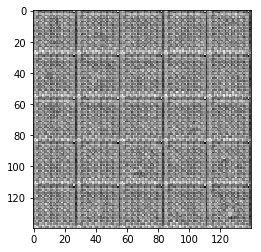

Epoch 1/3... Discriminator Loss: 1.0266... Generator Loss: 1.5239
Epoch 1/3... Discriminator Loss: 0.9272... Generator Loss: 1.2916
Epoch 1/3... Discriminator Loss: 0.9542... Generator Loss: 1.6113
Epoch 1/3... Discriminator Loss: 1.1716... Generator Loss: 0.6785
Epoch 1/3... Discriminator Loss: 1.4318... Generator Loss: 0.5040
Epoch 1/3... Discriminator Loss: 1.0362... Generator Loss: 0.8923
Epoch 1/3... Discriminator Loss: 1.1648... Generator Loss: 1.1639
Epoch 1/3... Discriminator Loss: 0.9832... Generator Loss: 1.1024
Epoch 1/3... Discriminator Loss: 0.6942... Generator Loss: 1.4926
Epoch 1/3... Discriminator Loss: 1.4364... Generator Loss: 1.0675


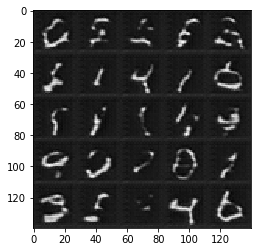

Epoch 1/3... Discriminator Loss: 1.0796... Generator Loss: 1.2511
Epoch 1/3... Discriminator Loss: 1.3560... Generator Loss: 0.5319
Epoch 1/3... Discriminator Loss: 1.0117... Generator Loss: 1.3701
Epoch 1/3... Discriminator Loss: 1.0325... Generator Loss: 1.5627
Epoch 1/3... Discriminator Loss: 1.0632... Generator Loss: 1.5057
Epoch 1/3... Discriminator Loss: 1.0562... Generator Loss: 1.4761
Epoch 1/3... Discriminator Loss: 1.6813... Generator Loss: 2.5809
Epoch 1/3... Discriminator Loss: 1.0064... Generator Loss: 0.9896
Epoch 1/3... Discriminator Loss: 1.1778... Generator Loss: 0.7672
Epoch 1/3... Discriminator Loss: 1.2076... Generator Loss: 0.7736


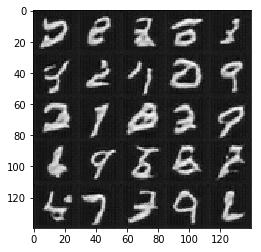

Epoch 1/3... Discriminator Loss: 1.0626... Generator Loss: 0.9802
Epoch 1/3... Discriminator Loss: 1.2285... Generator Loss: 0.6854
Epoch 1/3... Discriminator Loss: 1.1358... Generator Loss: 1.2701
Epoch 1/3... Discriminator Loss: 1.0173... Generator Loss: 1.0350
Epoch 1/3... Discriminator Loss: 1.4498... Generator Loss: 0.5034
Epoch 1/3... Discriminator Loss: 1.2043... Generator Loss: 1.3131
Epoch 2/3... Discriminator Loss: 1.1613... Generator Loss: 0.8874
Epoch 2/3... Discriminator Loss: 1.2364... Generator Loss: 1.6980
Epoch 2/3... Discriminator Loss: 1.3941... Generator Loss: 0.5555
Epoch 2/3... Discriminator Loss: 1.1287... Generator Loss: 1.0397


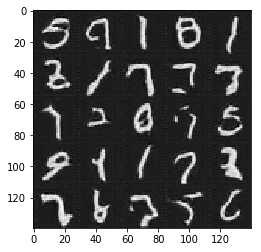

Epoch 2/3... Discriminator Loss: 1.2310... Generator Loss: 1.0516
Epoch 2/3... Discriminator Loss: 1.1924... Generator Loss: 0.8045
Epoch 2/3... Discriminator Loss: 1.4914... Generator Loss: 0.5129
Epoch 2/3... Discriminator Loss: 1.1937... Generator Loss: 0.9727
Epoch 2/3... Discriminator Loss: 1.1287... Generator Loss: 0.9965
Epoch 2/3... Discriminator Loss: 1.3911... Generator Loss: 0.5420
Epoch 2/3... Discriminator Loss: 1.1413... Generator Loss: 1.3721
Epoch 2/3... Discriminator Loss: 1.3546... Generator Loss: 0.5423
Epoch 2/3... Discriminator Loss: 1.1941... Generator Loss: 0.6726
Epoch 2/3... Discriminator Loss: 1.1734... Generator Loss: 0.9418


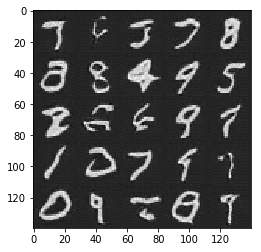

Epoch 2/3... Discriminator Loss: 1.1498... Generator Loss: 1.2562
Epoch 2/3... Discriminator Loss: 1.1194... Generator Loss: 0.9458
Epoch 2/3... Discriminator Loss: 1.1363... Generator Loss: 1.0875
Epoch 2/3... Discriminator Loss: 1.2191... Generator Loss: 0.9642
Epoch 2/3... Discriminator Loss: 1.3902... Generator Loss: 0.5974
Epoch 2/3... Discriminator Loss: 1.2035... Generator Loss: 0.8208
Epoch 2/3... Discriminator Loss: 1.1151... Generator Loss: 1.2471
Epoch 2/3... Discriminator Loss: 1.4843... Generator Loss: 0.4717
Epoch 2/3... Discriminator Loss: 1.1827... Generator Loss: 0.8670
Epoch 2/3... Discriminator Loss: 1.2795... Generator Loss: 0.6950


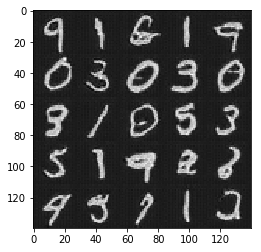

Epoch 2/3... Discriminator Loss: 1.5579... Generator Loss: 1.8165
Epoch 2/3... Discriminator Loss: 1.1526... Generator Loss: 0.9340
Epoch 2/3... Discriminator Loss: 1.1209... Generator Loss: 1.2271
Epoch 2/3... Discriminator Loss: 1.2592... Generator Loss: 0.6817
Epoch 2/3... Discriminator Loss: 1.3176... Generator Loss: 0.6340
Epoch 2/3... Discriminator Loss: 1.4910... Generator Loss: 1.5321
Epoch 2/3... Discriminator Loss: 1.2275... Generator Loss: 0.9540
Epoch 2/3... Discriminator Loss: 1.2059... Generator Loss: 0.7111
Epoch 2/3... Discriminator Loss: 1.2509... Generator Loss: 0.8567
Epoch 2/3... Discriminator Loss: 1.2471... Generator Loss: 1.0535


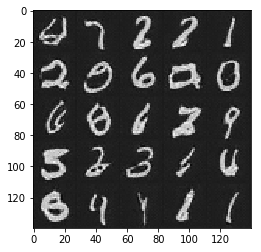

Epoch 2/3... Discriminator Loss: 1.2176... Generator Loss: 0.8763
Epoch 2/3... Discriminator Loss: 1.2623... Generator Loss: 1.4555
Epoch 2/3... Discriminator Loss: 1.2798... Generator Loss: 0.7172
Epoch 2/3... Discriminator Loss: 1.2705... Generator Loss: 0.7120
Epoch 2/3... Discriminator Loss: 1.1849... Generator Loss: 0.9214
Epoch 2/3... Discriminator Loss: 1.3828... Generator Loss: 0.5244
Epoch 2/3... Discriminator Loss: 1.2628... Generator Loss: 1.1470
Epoch 2/3... Discriminator Loss: 1.2644... Generator Loss: 0.9012
Epoch 2/3... Discriminator Loss: 1.2944... Generator Loss: 0.8237
Epoch 2/3... Discriminator Loss: 1.2234... Generator Loss: 0.8499


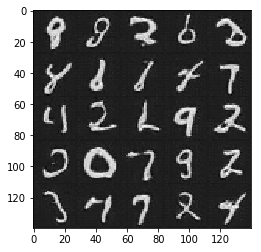

Epoch 2/3... Discriminator Loss: 1.3411... Generator Loss: 0.8141
Epoch 2/3... Discriminator Loss: 1.2565... Generator Loss: 0.7350
Epoch 2/3... Discriminator Loss: 1.3222... Generator Loss: 0.9901
Epoch 3/3... Discriminator Loss: 1.2932... Generator Loss: 0.6262
Epoch 3/3... Discriminator Loss: 1.2946... Generator Loss: 0.8666
Epoch 3/3... Discriminator Loss: 1.2573... Generator Loss: 0.9474
Epoch 3/3... Discriminator Loss: 1.3375... Generator Loss: 0.6808
Epoch 3/3... Discriminator Loss: 1.2557... Generator Loss: 1.0026
Epoch 3/3... Discriminator Loss: 1.2243... Generator Loss: 1.2534
Epoch 3/3... Discriminator Loss: 1.3224... Generator Loss: 1.3819


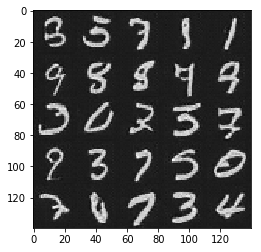

Epoch 3/3... Discriminator Loss: 1.3614... Generator Loss: 0.6086
Epoch 3/3... Discriminator Loss: 1.2481... Generator Loss: 0.9887
Epoch 3/3... Discriminator Loss: 1.2739... Generator Loss: 0.7624
Epoch 3/3... Discriminator Loss: 1.2468... Generator Loss: 1.1458
Epoch 3/3... Discriminator Loss: 1.1968... Generator Loss: 0.9158
Epoch 3/3... Discriminator Loss: 1.3112... Generator Loss: 0.7067
Epoch 3/3... Discriminator Loss: 1.2718... Generator Loss: 0.7832
Epoch 3/3... Discriminator Loss: 1.3185... Generator Loss: 0.9685
Epoch 3/3... Discriminator Loss: 1.3099... Generator Loss: 0.7523
Epoch 3/3... Discriminator Loss: 1.2024... Generator Loss: 1.0241


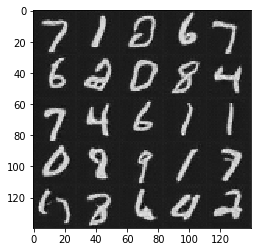

Epoch 3/3... Discriminator Loss: 1.3218... Generator Loss: 0.7645
Epoch 3/3... Discriminator Loss: 1.4591... Generator Loss: 0.5102
Epoch 3/3... Discriminator Loss: 1.4032... Generator Loss: 0.6285
Epoch 3/3... Discriminator Loss: 1.2339... Generator Loss: 1.1131
Epoch 3/3... Discriminator Loss: 1.2636... Generator Loss: 0.8918
Epoch 3/3... Discriminator Loss: 1.3593... Generator Loss: 0.6209
Epoch 3/3... Discriminator Loss: 1.2147... Generator Loss: 1.3579
Epoch 3/3... Discriminator Loss: 1.2435... Generator Loss: 0.8232
Epoch 3/3... Discriminator Loss: 1.3614... Generator Loss: 1.1530
Epoch 3/3... Discriminator Loss: 1.3402... Generator Loss: 0.7001


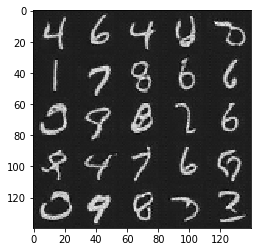

Epoch 3/3... Discriminator Loss: 1.2621... Generator Loss: 0.9375
Epoch 3/3... Discriminator Loss: 1.2730... Generator Loss: 0.8678
Epoch 3/3... Discriminator Loss: 1.5535... Generator Loss: 0.4591
Epoch 3/3... Discriminator Loss: 1.3692... Generator Loss: 0.6343
Epoch 3/3... Discriminator Loss: 1.2923... Generator Loss: 0.7314
Epoch 3/3... Discriminator Loss: 1.2853... Generator Loss: 0.8562
Epoch 3/3... Discriminator Loss: 1.3289... Generator Loss: 0.9729
Epoch 3/3... Discriminator Loss: 1.3219... Generator Loss: 0.8928
Epoch 3/3... Discriminator Loss: 1.3110... Generator Loss: 1.0383
Epoch 3/3... Discriminator Loss: 1.3789... Generator Loss: 0.6791


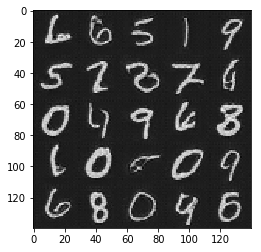

Epoch 3/3... Discriminator Loss: 1.3614... Generator Loss: 1.0406
Epoch 3/3... Discriminator Loss: 1.3695... Generator Loss: 0.7482
Epoch 3/3... Discriminator Loss: 1.2411... Generator Loss: 0.9079
Epoch 3/3... Discriminator Loss: 1.4379... Generator Loss: 0.5268
Epoch 3/3... Discriminator Loss: 1.3447... Generator Loss: 0.5994
Epoch 3/3... Discriminator Loss: 1.3205... Generator Loss: 0.9188
Epoch 3/3... Discriminator Loss: 1.2632... Generator Loss: 0.7275
Epoch 3/3... Discriminator Loss: 1.2251... Generator Loss: 0.9408
Epoch 3/3... Discriminator Loss: 1.4799... Generator Loss: 0.5261
Epoch 3/3... Discriminator Loss: 1.3062... Generator Loss: 0.7648


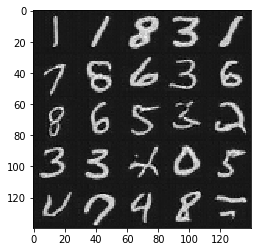

Training Finished!


In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 2.9846... Generator Loss: 0.1074
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 5.0627
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 2.1565... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 2.5375
Epoch 1/2... Discriminator Loss: 1.6916... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.8465... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 1.7714... Generator Loss: 0.5865
Epoch 1/2... Discriminator Loss: 2.0702... Generator Loss: 0.4203


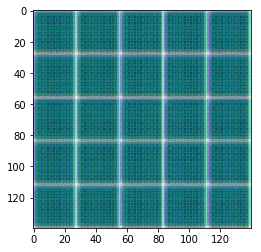

Epoch 1/2... Discriminator Loss: 1.6623... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.8768
Epoch 1/2... Discriminator Loss: 1.6924... Generator Loss: 0.4404
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.8319
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 2.0882
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.8001... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.7791... Generator Loss: 0.4371
Epoch 1/2... Discriminator Loss: 1.5647... Generator Loss: 0.5732


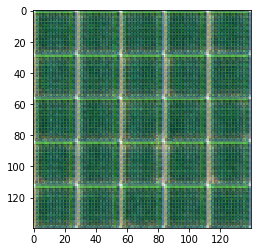

Epoch 1/2... Discriminator Loss: 1.6533... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.3468
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 1.6996... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.2000... Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 1.6064
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.6638


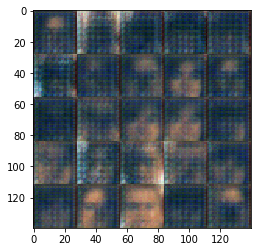

Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 1.2415
Epoch 1/2... Discriminator Loss: 1.5916... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 1.4703
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 1.4451
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.3831
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.9016


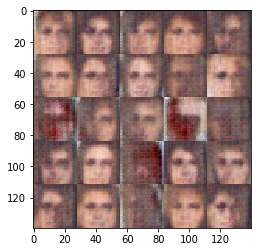

Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.6502
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 1.0847
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 1.1749
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 1.0988
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 1.8695


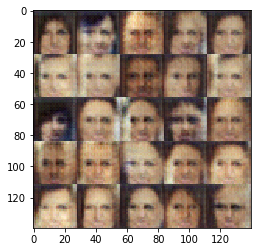

Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.9651
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.8707
Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.0970
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 1.0374
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.6268... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.8739


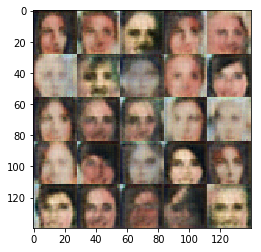

Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 2.1526... Generator Loss: 0.2474
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.6944... Generator Loss: 0.4205
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 0.9209
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 1.5372... Generator Loss: 0.5861
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.9387


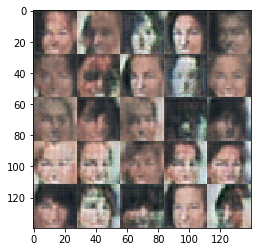

Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.9732
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 1.1663
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 1.6529
Epoch 1/2... Discriminator Loss: 1.3460... Generator Loss: 0.7352
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 1.6672... Generator Loss: 1.4875
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.6389
Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 1.1259
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.7414


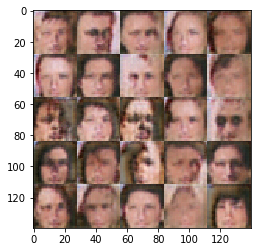

Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 1.2214
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.9632
Epoch 1/2... Discriminator Loss: 1.6222... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 1.4627
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.8716


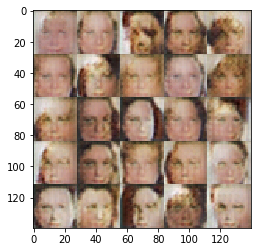

Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 1.5180
Epoch 1/2... Discriminator Loss: 1.6714... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 1.5337
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 1.5498
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.9803
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 0.8824
Epoch 1/2... Discriminator Loss: 1.6077... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 1.0797


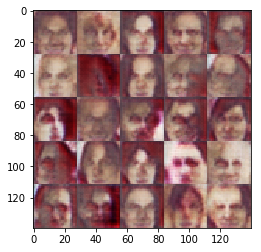

Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.6250
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 1.0196
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 1.1299
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.9158


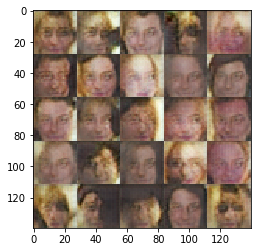

Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.6301... Generator Loss: 1.1615
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 1.2201
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.6958


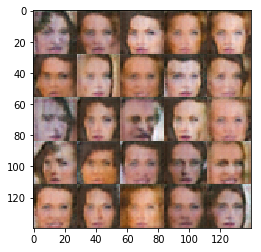

Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.7473... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 1.5957... Generator Loss: 0.5716
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 1.1582
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 1.6302... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 1.0208


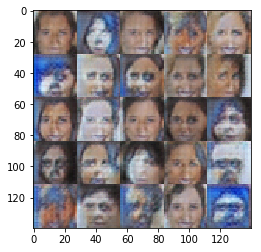

Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.0172
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.9637
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 2.0739


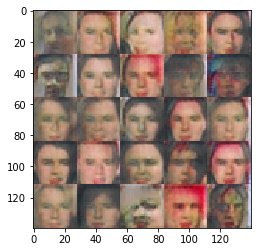

Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.4465... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.9545
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.6996


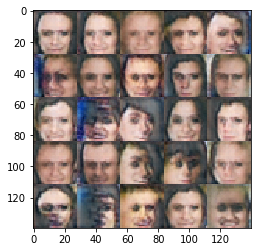

Epoch 1/2... Discriminator Loss: 1.5081... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.6614... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.9109
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 1.0970
Epoch 2/2... Discriminator Loss: 1.5142... Generator Loss: 1.1665
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 1.0799


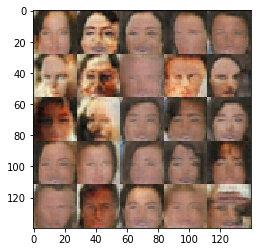

Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.9426
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.5907... Generator Loss: 0.5027
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.9643
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 1.1856
Epoch 2/2... Discriminator Loss: 1.4119... Generator Loss: 0.6773


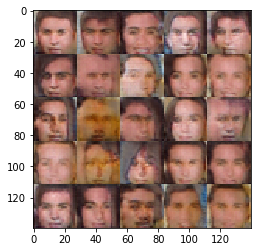

Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 1.4160
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 1.0520
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.5671... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.5048... Generator Loss: 0.7225


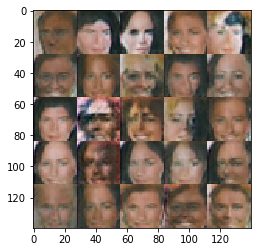

Epoch 2/2... Discriminator Loss: 1.6555... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.9025
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.6445... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 1.5938... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.7008
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.6011... Generator Loss: 0.6159


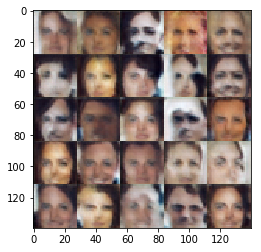

Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 1.6549... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.6084... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 1.4913... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.8046


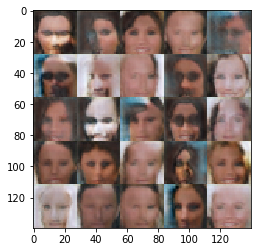

Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.6145
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 1.5668... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.5228... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 1.5674... Generator Loss: 0.8001


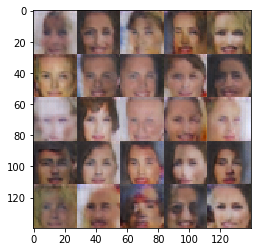

Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 1.6155... Generator Loss: 0.7460
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.7474


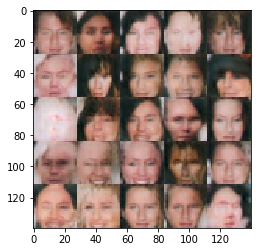

Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.5250... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.7147
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.9790
Epoch 2/2... Discriminator Loss: 1.4923... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 1.1216
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.8666


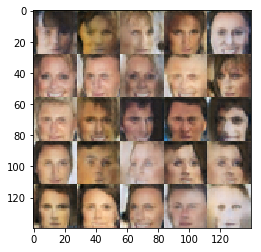

Epoch 2/2... Discriminator Loss: 1.5342... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.4579... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.7454
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 1.5389... Generator Loss: 0.6051
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.5808... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 1.1255
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.6389


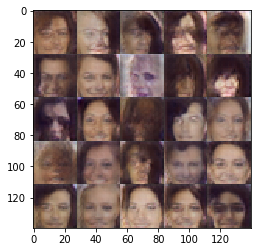

Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.4245... Generator Loss: 0.7552


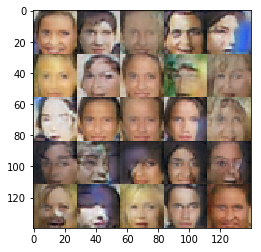

Epoch 2/2... Discriminator Loss: 1.4842... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 1.4168... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 1.5056... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.8706


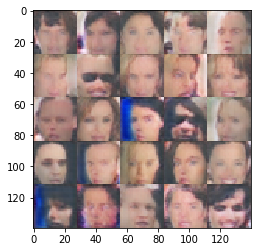

Epoch 2/2... Discriminator Loss: 1.5786... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.4768... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.4821... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.5065... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.6147... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.7456


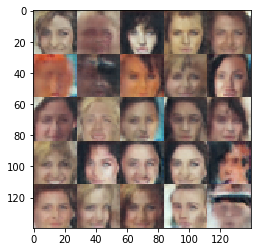

Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.7852
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.9494
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 1.4734... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.7082


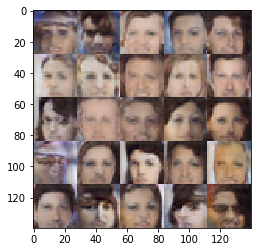

Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 1.4288... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.4132... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.5070... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 1.4739... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.9792


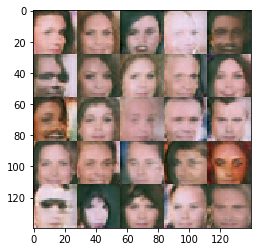

Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 1.4865... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.4274... Generator Loss: 0.9233
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.8715


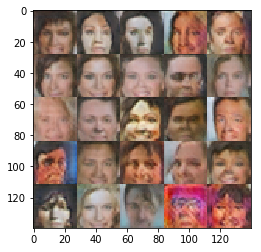

Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.7228
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.4807... Generator Loss: 0.5669
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.9347
Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.6525


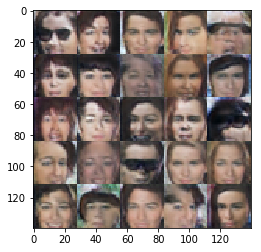

Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 0.5478
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.8512
Training Finished!


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.